<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">


<h1 align="center" style="margin-bottom: -10px">Прогнозирование заказов такси<a class="tocSkip"></h1>
<h4 align="center" style="margin-bottom: 60px">Учебный проект, Яндекс Практикум<a class="tocSkip"></h4>
<h4 align="right" style="margin-bottom: -15px">Исполнитель: Воронин Артём<a class="tocSkip"></h4> 

<h1 align="center">Описание проекта</h1>
<p style="margin-bottom: 30px"></p>
<h2>Задача:<span class="tocSkip"></span></h2>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<p style="margin-bottom: 30px"></p>
<h2> Описание данных:  <span class="tocSkip"></span></h2>

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# 0 Подготовка к работе

## 0.1 Установка пакетов

In [1]:
!pip install lightgbm --quiet --disable-pip-version-check
!pip install catboost --quiet --disable-pip-version-check

## 0.2 Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import *

from copy import deepcopy

## 0.3 Загрузка даных

In [3]:
def data_load(name):
    '''Загружает датасет из файла'''
    
    home_dir = os.path.abspath("")
    
    try:
        data = pd.read_csv(f'{home_dir}/{name}', index_col=[0], parse_dates=True)
        print('Датасет успешно загружен с локалки!')
        return data    
    except:
        try:
            data = pd.read_csv(f'https://code.s3.yandex.net/datasets/{name}',
                              index_col=[0], parse_dates=True)
            print('Датасет успешно загружен с yandex!')
            return data
        except:  
            print(f'Ошибка месторасположения csv-файла "{name}"')

In [4]:
data = data_load('taxi.csv')

Датасет успешно загружен с локалки!


**Вывод:** Данные успешно загружены, ошибок в файле и датасете нет.

# 1 Обзор и предобработка данных

## 1.1 Предварительный обзор

In [5]:
display(data.sample(8))
print()
data.info()

,num_orders
datetime,
2018-03-14 00:00:00,17
2018-07-24 10:50:00,20
2018-04-08 22:30:00,11
2018-04-22 09:30:00,9
2018-07-08 05:10:00,15
2018-04-24 04:20:00,1
2018-04-12 15:10:00,10
2018-05-28 08:50:00,11



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Пропуски**

In [6]:
def pass_value_barh(df, figsize=(11, 5), fontsize=10):
    '''Строит гистограмму пропусков и их долю в %'''
    
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=figsize, legend=False, fontsize=fontsize)
            .set_title('Гистограмма пропусков' + "\n", fontsize=16, color='SteelBlue')    
        );   
        print('\nДоля пропусков: {:.2%}'.format(df.isna().mean().mean()))
    except:
        plt.close();
        print('Пропусков нет 😎')

In [7]:
pass_value_barh(data)

Пропусков нет 😎


**Дубликаты**

In [8]:
print(f'Кол-во явных дубликатов: {data.duplicated().sum()}')

Кол-во явных дубликатов: 26415


**Вывод:** 

- данные состоят из 1 таблицы размером 26496 × 2, один столбец установлен в качестве индекса
- тип данных целочисленный
- пропусков в данных нет
- дубликатов в данных нет

## 1.2 Ресемплирование данных по одному часу

Перед ресемплированием упорядочим данные:

In [9]:
if not data.index.is_monotonic_increasing:
    data.sort_index(inplace=True)
    
data = data.resample('1H').sum()

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
print( 'Минимальный индекс: ', data.index.min(), 
       '\nМаксимальный индекс: ', data.index.max()  )

Минимальный индекс:  2018-03-01 00:00:00 
Максимальный индекс:  2018-08-31 23:00:00


# 2 Анализ данных

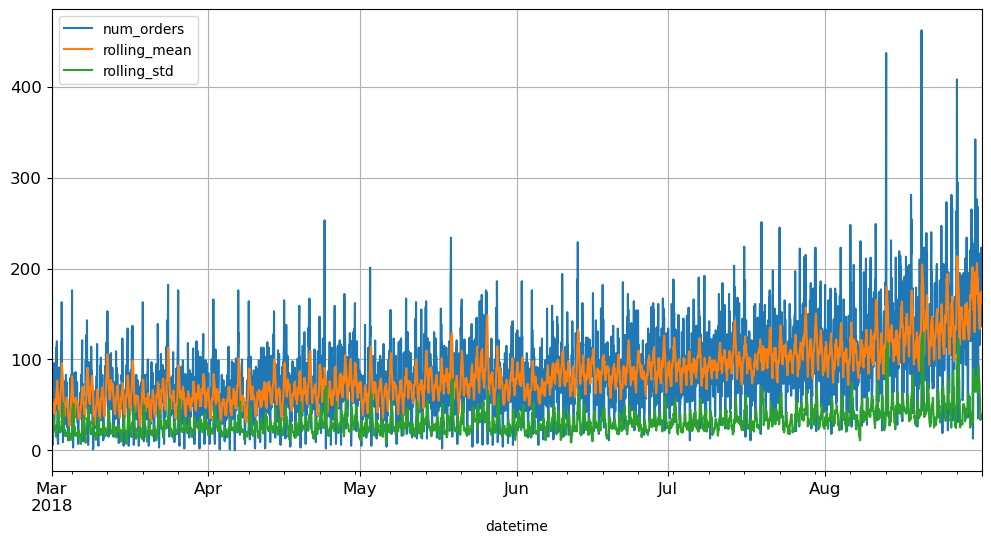

In [11]:
data["rolling_mean"] = data["num_orders"].rolling(10).mean()
data["rolling_std"] = data["num_orders"].rolling(10).std()

data.plot(figsize=(12, 6), grid=True, fontsize=12);

В принципе ряд достаточно стационаерен. Посмотрим сильно ли меняется картина, если получить разность ряда:

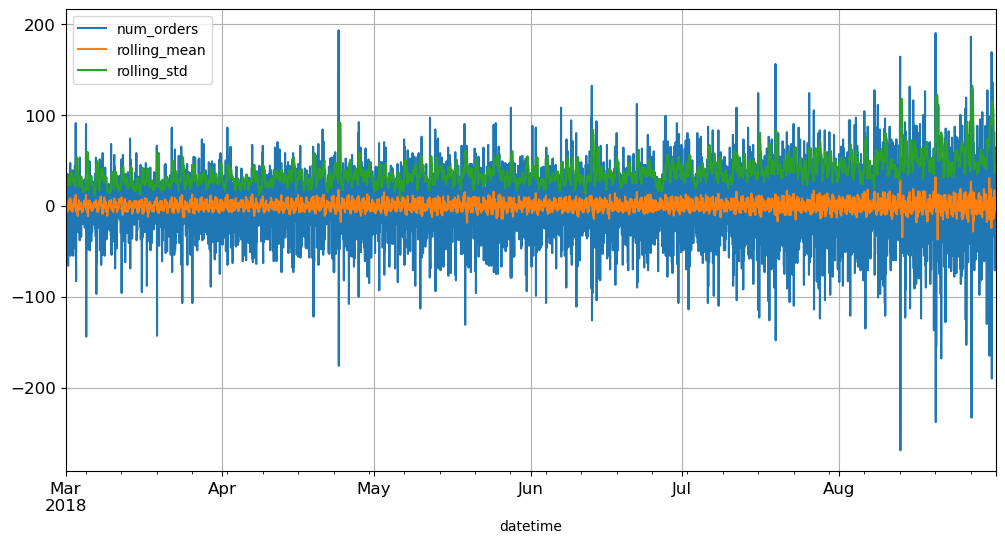

In [12]:
data_shift = data - data.shift()

data_shift["rolling_mean"] = data_shift["num_orders"].rolling(10).mean()
data_shift["rolling_std"] = data_shift["num_orders"].rolling(10).std()

data_shift.plot(figsize=(12, 6), grid=True, fontsize=12);

Ряд стал более стационарным. Проверим ряд на стационарность с помощью теста Дики — Фуллера. Используем пороговое значение, равное 0,05 (5%) и сформулируем гипотезы:

**Нулевая гипотеза:** Ряд нестационарен.

**Альтернативная гиоптеза:** Ряд стационарен.

In [13]:
p_value = adfuller(data['num_orders'], regression='ctt')[1]

print(f'Ряд {("не ", "")[bool(p_value < 0.05)]}стационарный')

Ряд стационарный


Проанализируем графики тренда и сезонности:

In [14]:
data = data.drop(['rolling_mean', 'rolling_std'], axis=1)

In [15]:
color = ['r', 'b', 'g', 'y', 'm', 'c', 'k']    # цвета для графиков

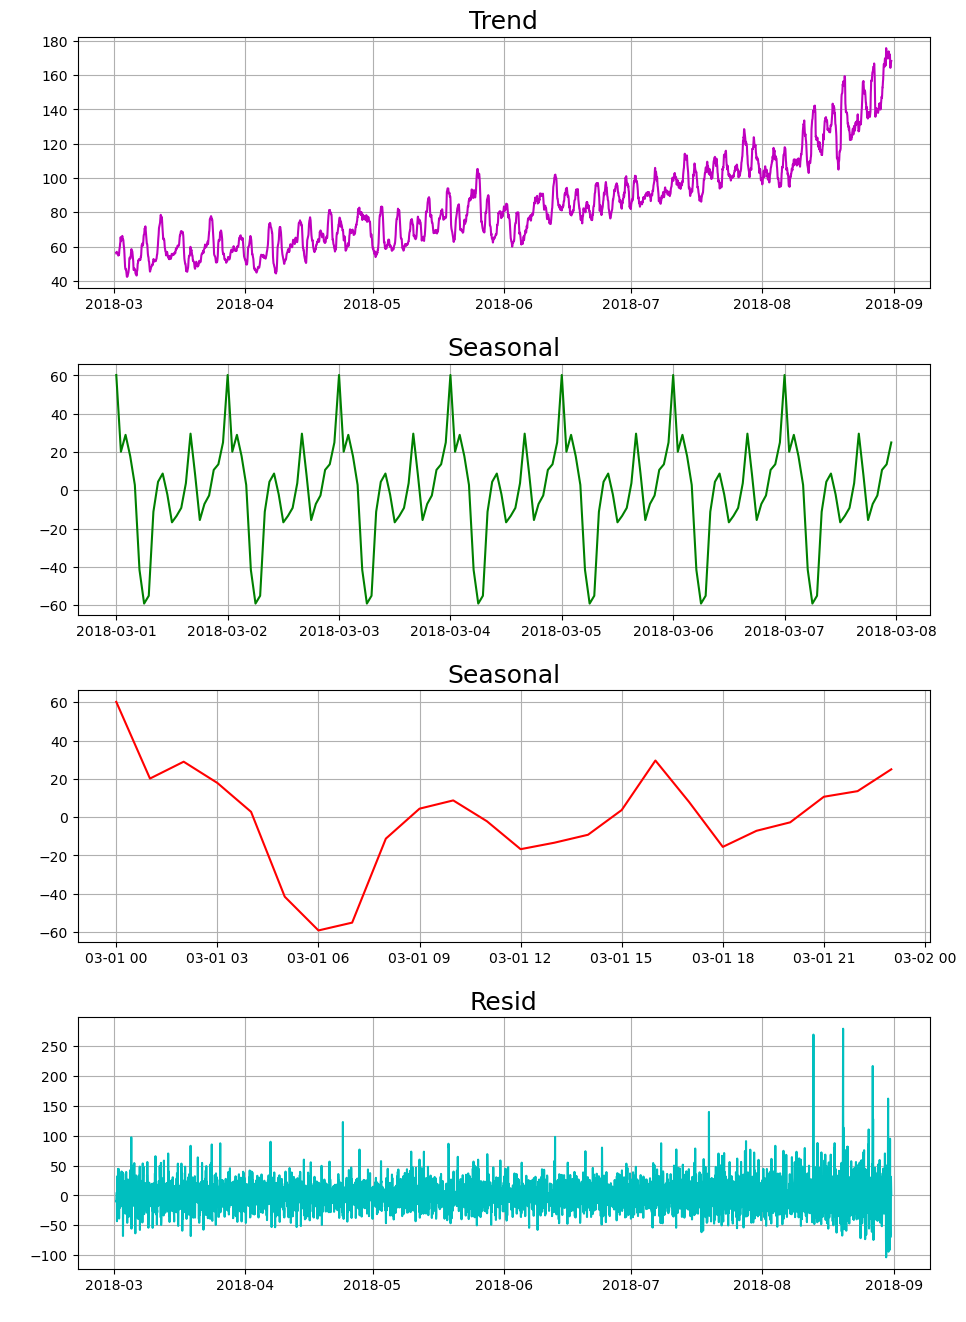

In [16]:
dec = seasonal_decompose(data.dropna())
color_shuffle = shuffle(color)


fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(11, 16))

fig.subplots_adjust(hspace=0.3)

for n, i in enumerate([dec.trend, dec.seasonal.head(24*7), 
                       dec.seasonal.head(24), dec.resid]):
    
    sns.lineplot(ax=ax[n], 
                 data=i,
                 color=color_shuffle[n])
    
    ax[n].set_title(i.name.capitalize(), fontsize=18)    
    ax[n].set_xlabel(' ')
    ax[n].set_ylabel(' ')
    ax[n].tick_params(axis='x', labelsize=10)
    ax[n].tick_params(axis='y', labelsize=10) 
    ax[n].grid('on')

**Вывод:** 

- по тренду можно сказать, что со временем все больше и больше людей пользуется услугой заказа такси;
- увеличение роста на спрос такси наблюдается с приходом летнего периода;
- к концу недели и в середине идет увеличение заказов;
- чаще всего такси заказывают 12 часов ночи;
- реже всего такси заказывают в 6 утра;
- в начале каждого дня идет пик на заказы, потом резкое падение, затем в течение дня количество заказов снова растет и к концу дня достигает нового пика.

# 3 Обучение моделей

## 3.1 Подготовка

Для начала создадим из индекса новые временные признаки:

In [17]:
data['hour'] = data.index.hour
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month

А так же создадим признаки из лагов и скользящего среднего:

In [18]:
def make_features(data, max_lag, rolling_mean_size):   
    '''функция создания признаков'''
    
    for lag in range(1, max_lag+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
make_features(data, 24, 10)

Теперь разделим данные на тренировочную и тестовую выборки:

In [20]:
data.dropna(inplace=True)

(x_train, x_test, 
 y_train, y_test) = ( train_test_split(data.drop('num_orders', axis=1), 
                                       data['num_orders'], 
                                       test_size=0.1,
                                       shuffle=False,
                                       random_state=321) ) 

# check
print('Размер обучающих выборок: ', x_train.shape, y_train.shape)
print('Размер тестовых выборок: ', x_test.shape, y_test.shape)

Размер обучающих выборок:  (3952, 29) (3952,)
Размер тестовых выборок:  (440, 29) (440,)


Так как стандартные инструменты кросс-валидации используют перемешивание данных, то нужно создать свой:

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

Для оценки качества моделей используем метрику RMSE. Напишем для неё функцию:

In [22]:
def RMSE_make(true, pred):
    return mean_squared_error(true, pred, squared=False)

RMSE = make_scorer(RMSE_make, greater_is_better=False)

Фнукция обучения и вывода информации:

In [23]:
def model_create(model, params):
    '''Создает и обучает модель перебором параметров. Находит метрику МАЕ'''
    
    mdl = GridSearchCV(model, params, cv=tscv, scoring=RMSE, n_jobs=-1)
    mdl.fit(x_train, y_train)
    score = abs(mdl.best_score_).round(3) 
    
    print(
        f'\nRMSE модели {model.__class__.__name__} = {score}',
        f'Лучшие гиперпараметры:',
        sep='\n\n'
    )
    display(mdl.best_params_)
    
    return mdl.best_estimator_, score

> **Примечание.** Гиперпараметры во всех моделях я подобрал заранее, перебрав широкие диапазоны. Для сокращения времени проверки преокта я лучшие гиперпараметры добавил сразу в грид.

## 3.2 RandomForestRegression

In [24]:
%%time

params = {
    'n_estimators': range(69, 70),       # 69   
    'max_depth': range(18, 19),          # 18   
    'min_samples_leaf': range(1, 2),     # 1
    'min_samples_split': range(2, 3),    # 2   
    'random_state': [321] 
}


model_rfc, rfc_score = model_create(RandomForestRegressor(), params)   # 25.179


RMSE модели RandomForestRegressor = 25.179

Лучшие гиперпараметры:


{'max_depth': 18,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 69,
 'random_state': 321}

CPU times: total: 5.19 s
Wall time: 10.8 s


## 3.3 CatBoost

In [25]:
%%time

params = { 
    'depth':  range(9, 10),                     #9 
    'n_estimators': range(24, 25),              #24 
    'learning_rate': [0.5],                     #0.5 
    'loss_function': ['RMSE'],                
    'silent': [True],
    'random_seed': [321]
}


model_cat, cat_score = model_create(CatBoostRegressor(), params)   #26.28


RMSE модели CatBoostRegressor = 26.28

Лучшие гиперпараметры:


{'depth': 9,
 'learning_rate': 0.5,
 'loss_function': 'RMSE',
 'n_estimators': 24,
 'random_seed': 321,
 'silent': True}

CPU times: total: 2.5 s
Wall time: 3.84 s


## 3.4 LinearRegression

In [26]:
RMSE_lr = make_scorer(RMSE_make)

model_lr = LinearRegression()

lr_score = cross_val_score(model_lr, x_train, y_train, 
                           scoring=RMSE_lr, cv=tscv).mean().round(2)  
model_lr.fit(x_train, y_train)

print('\nRMSE модели линейной регрессии  =', lr_score)


RMSE модели линейной регрессии  = 26.95


## 3.5 LightGBM

In [27]:
%%time

params = { 
    'max_depth': range(8, 9),         #8           
    'n_estimators': range(6, 7),      #6                     
    'learning_rate': [0.5],           #0.5           
    'boosting_type': ['gbdt'],           
    'metric': ['rmse'],           
    'random_state': [321]
}


model_lgbm, lgbm_score = model_create(LGBMRegressor(), params)  #26.381

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4877
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 29
[LightGBM] [Info] Start training from score 78.451417

RMSE модели LGBMRegressor = 26.381

Лучшие гиперпараметры:


{'boosting_type': 'gbdt',
 'learning_rate': 0.5,
 'max_depth': 8,
 'metric': 'rmse',
 'n_estimators': 6,
 'random_state': 321}

CPU times: total: 359 ms
Wall time: 1.4 s


# 4 Анализ моделей

Выделим из нашей тренировочной выборки валидационную. Это нужно лишь для того, чтобы посчитать время обучения и предсказания моделей с уже найденными ранее гиперпараметрами. Лучшую RMSE метрику по каждой моделе мы уже нашли на кроссвалидации в предыдущем разделе.

In [28]:
x_train_tmp, x_valid_tmp, y_train_tmp, y_valid_tmp = (                        
            train_test_split(x_train,
                             y_train,
                             test_size=0.25,
                             shuffle=False,
                             random_state=321)    
    )

# check
print('Размер обучающих выборок: ', x_train_tmp.shape, y_train_tmp.shape)
print('Размер валидационных выборок: ', x_valid_tmp.shape, y_valid_tmp.shape)

Размер обучающих выборок:  (2964, 29) (2964,)
Размер валидационных выборок:  (988, 29) (988,)


Напишем функцию для определения параметров модели:

In [29]:
columns = ['Время обучения', 'Время предсказания', 'RMSE', 'Модель']

def model_time(model, score,
               features_train=x_train_tmp,
               target_train=y_train_tmp,
               features_valid=x_valid_tmp):
    
    mdl = deepcopy(model)
    start = time.time()
    mdl.fit(features_train, target_train)
    time_fit = time.time() - start
    mdl.predict(features_valid)
    time_predict = time.time() - time_fit - start
    
    return pd.DataFrame( [[round(time_fit, 3), round(time_predict, 3), 
                           score, model.__class__.__name__ ]], 
                        columns=columns )

Проведем анализ моделей. Результаты запишем в таблицу *result*:

In [30]:
result = pd.DataFrame(columns=columns)

# находим все параметры моделей в цикле и добавляем в result
for i in ['rfc', 'cat', 'lr', 'lgbm']:    
    params = model_time(eval(f'model_{i}'), eval(f'{i}_score'))
    result = pd.concat([result, params])  

    
result.set_index(['Модель'], inplace=True, drop=True)                          # делаем индексом название модели
multicolumns = zip(['Кросс-Валидация']*len(result.columns), result.columns)    # формируем список мультииндексов
result.columns = pd.MultiIndex.from_tuples(multicolumns)                       # делаем названия столбцов с мультииндексом

result

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4271
[LightGBM] [Info] Number of data points in the train set: 2964, number of used features: 29
[LightGBM] [Info] Start training from score 69.995277
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Кросс-Валидация                           
                       Время обучения Время предсказания    RMSE
Модель                                                          
RandomForestRegressor           3.887              0.016  25.179
CatBoostRegressor               0.628              0.011  26.280
LinearRegression                0.018              0.012  26.950
LGBMRegressor                   0.031              0.012  26.381

**Вывод:** На этапе анализа по моему мнению все модели показали хороший результат. Модель линейной регрессии выделяется чуть более худшей RMSE метрикой, но наилучшими параметрами времени обучения и предсказания. Выделить какую-то лушчую модель тяжело, но по RMSE метрике это модель случайного леса.

# 5 Тестирование

In [31]:
predictions = model_rfc.predict(x_test)

In [32]:
print('RMSE модели RandomForestRegressor на тестовой выборке',
      round(RMSE_make(y_test, predictions), 2))

RMSE модели RandomForestRegressor на тестовой выборке 41.49


Если критерий по времени имеет больший вес, чем критерий по метрике качества, то выбор будет в пользу модели LinearRegression.

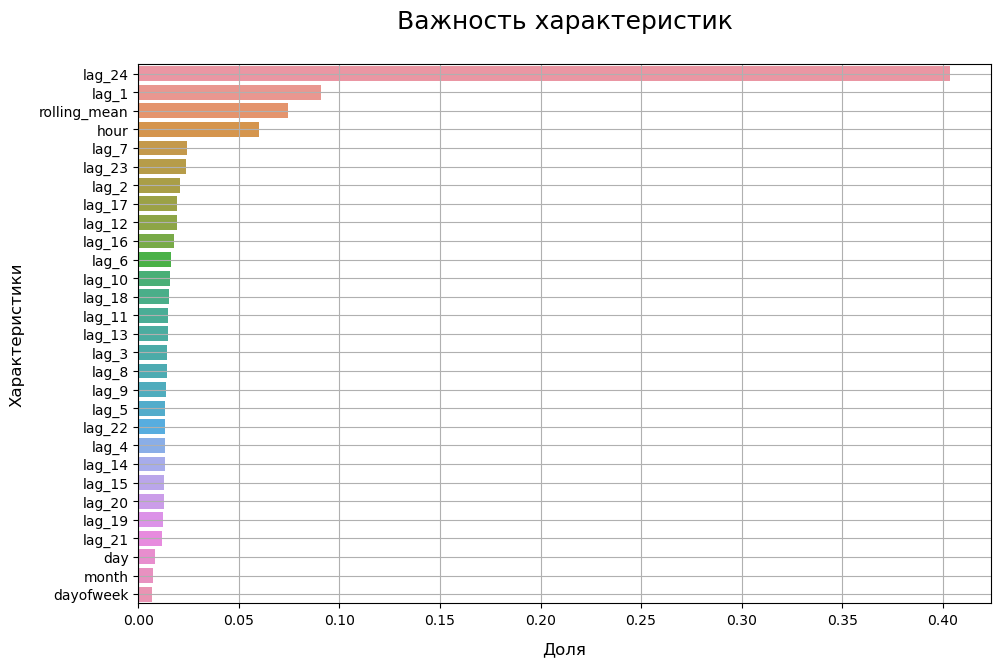

In [33]:
feature_importances = pd.Series(model_rfc.feature_importances_, x_train.columns)
feature_importances.sort_values(inplace=True, ascending=False)

plt.figure(figsize=(11, 7))
sns.barplot(x=feature_importances.values,
            y=feature_importances.index,            
            orient='h');
plt.title('Важность характеристик\n', fontsize=18)
plt.xlabel('Доля', fontsize=12, labelpad=10)
plt.ylabel('Характеристики', fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid('on')
plt.show()


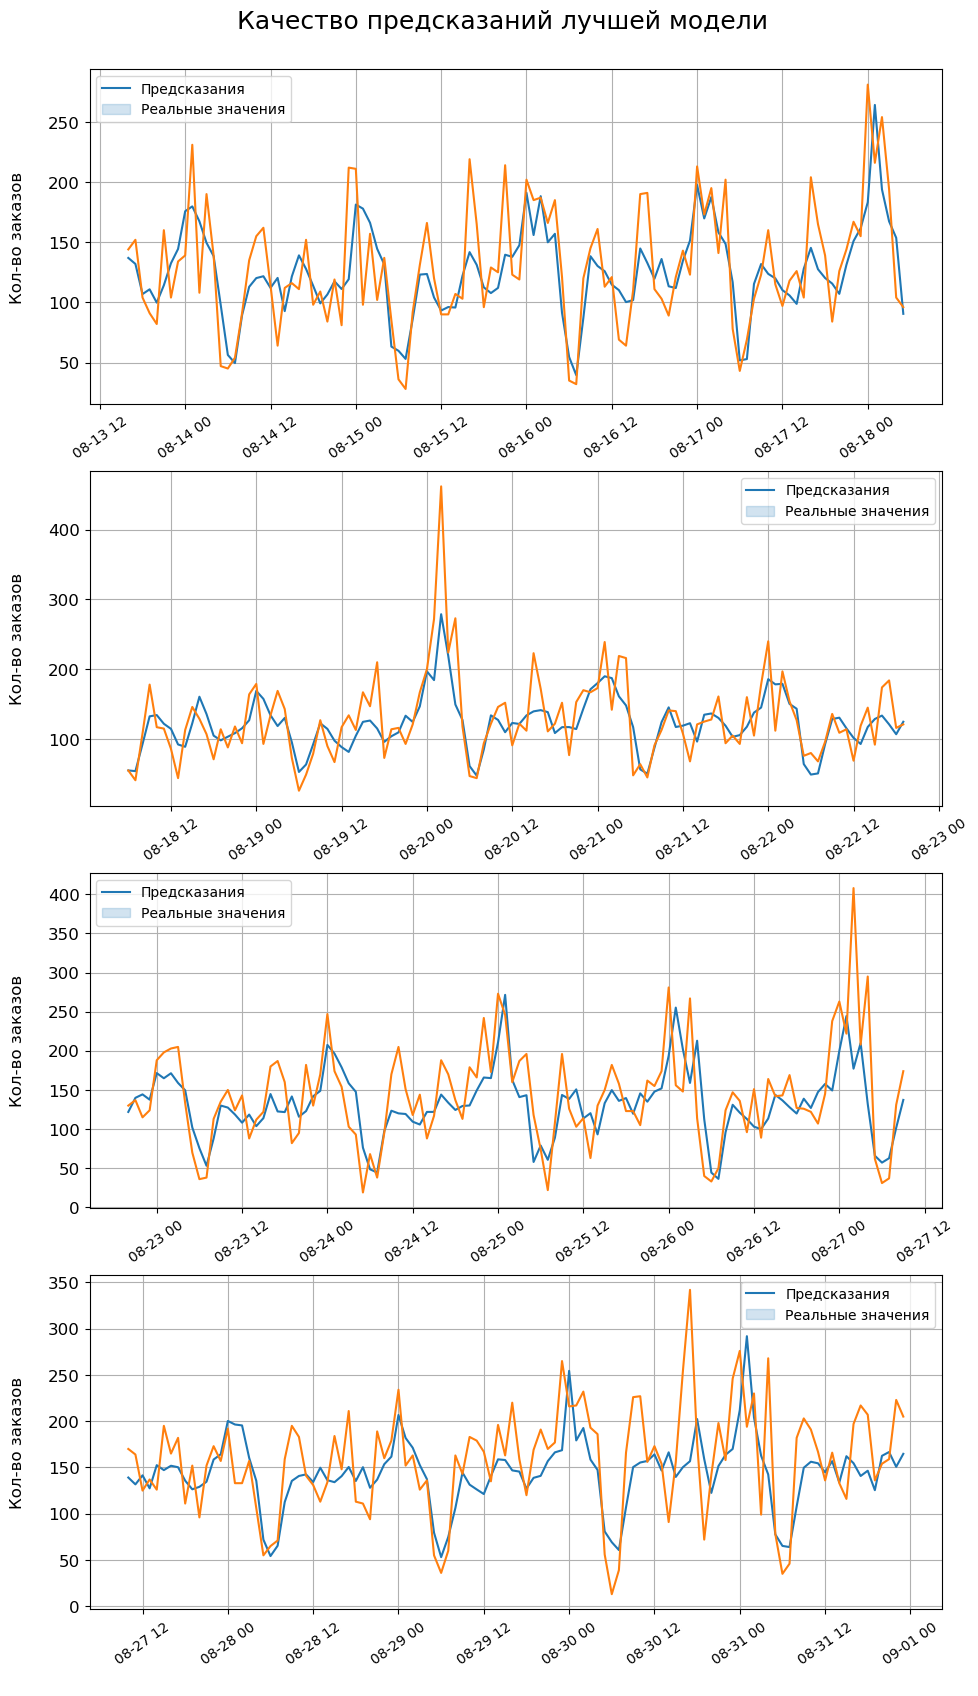

In [34]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(11, 20))
fig.suptitle('Качество предсказаний лучшей модели', fontsize=18, y=0.91)

for n, i in enumerate(range(0, len(y_test) - 1, len(y_test)//4)):
    
    j = i + len(y_test)//4
        
    sns.lineplot(y=predictions[i:j], x=y_test.index[i:j], ax=ax[n])
    sns.lineplot(y=y_test[i:j], x=y_test.index[i:j], ax=ax[n])
    ax[n].legend(['Предсказания', 'Реальные значения'])
    ax[n].set_xlabel(' ')
    ax[n].set_ylabel('Кол-во заказов\n', fontsize=12)
    ax[n].tick_params(axis='x', labelsize=10, rotation=35)
    ax[n].tick_params(axis='y', labelsize=12) 
    ax[n].grid('on')

<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">

<h1 align="center", style="margin-bottom: 15px">ВЫВОДЫ</h1>


В ходе проведенной работы была разработана модель на базе модели RandomForest, прогнозирующая количество заказов такси на следующий час.

Метрика RMSE модели RandomForestRegression на тестовой выборке = **41.49**.

Гиперпараметры модели:

<table> 
<tr>
  <th>Параметр</th>
  <th>значение</th>
</tr>
<tr>
  <th>n_estimators</th>
  <td>69</td>
</tr> 
<tr>
  <th>max_depth</th>
  <td>18</td>
</tr>
<tr>
  <th>min_samples_leaf</th>
  <td>1</td>
</tr>    
<tr>
  <th>min_samples_split</th>
  <td>2</td>
</tr>
</table>

<p style="margin-bottom: 30px"></p>
В ходе анализа данных было выявлено:

- со временем все больше и больше людей пользуется услугой заказа такси
- увеличение роста на спрос такси наблюдается с приходом летнего периода
- к концу недели и в середине идет увеличение заказов
- чаще всего такси заказывают 12 часов ночи
- реже всего такси заказывают в 6 утра
- в начале каждого дня идет пик на заказы, потом резкое падение, затем в течение дня количество заказов снова растет и к концу дня достигает нового пика

<p style="margin-bottom: 30px"></p>
Всего в ходе работы было обучено 4 модели, подобраны для них гиперпараметры, проведен анализ метрик моделей:

<table>
<tr>
  <th>Модель</th>
  <th>RMSE</th>
  <th>Время обучения</th>
  <th>Время предсказания</th>
</tr>
<tr>
  <td>RandomForestRegressor</td>
  <td>25.179</td>
  <td>3.887</td>
  <td>0.016</td>
</tr>    
<tr>
  <td>CatBoostRegressor</td>
  <td>26.280</td>
  <td>0.628</td>
  <td>0.011</td>
</tr>   
<tr>
  <td>LinearRegression</td>
  <td>26.950</td>
  <td>0.018</td>
  <td>0.012</td>
</tr> 
<tr>
  <td>LGBMRegressor</td>
  <td>26.381</td>
  <td>0.031</td>
  <td>0.012</td>
</tr>
</table>


<p style="margin-bottom: 30px"></p>
По моему мнению все модели показали хороший результат. Модель линейной регрессии выделяется чуть более худшей RMSE метрикой, но наилучшими параметрами времени обучения и предсказания. Наилучшая метрика RMSE у модели случайного леса.



***